# SQL Agent

In [31]:
# %pip install -q psycopg2-binary
%pip install -q python-dotenv
%pip install -q langchain_community
%pip install -q langchain-openai
%pip install -q langgraph

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# import psycopg2
import os
from dotenv import load_dotenv

In [2]:
load_dotenv("/Users/tariqmehmood/code/cs-6303/RAG-Enterprise-Chatbot/sql_agent/.env", override=True)
DATABASE_URI_RW=os.environ.get("DATABASE_URI_RW")
OPENAI_API_KEY=os.environ.get("OPENAI_API_KEY")
TAVILY_API_KEY=os.environ["TAVILY_API_KEY"]

In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri(DATABASE_URI_RW)
# print(db.dialect)
# print(db.get_usable_table_names())
db.run("SELECT * FROM customers LIMIT 1;")
# db.run(" INSERT INTO Restaurants (Name, Location, CuisineType, Rating, HoursOfOperation) VALUES ('dummy', 'dummy', 'dummy', 4.5, '9:00 AM - 11:00 PM')")

"[(1, 'Ali Ahmed', 'ali.ahmed@example.com', '03001234567', 'Gulberg, Lahore', 'Visa ****1234', 120, datetime.datetime(2024, 10, 20, 12, 4, 37, 63089))]"

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
from langchain_core.prompts import SystemMessagePromptTemplate

system_template_sql_agent = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
If you get an InsufficientPrivilege error, respond with the following message:

“I'm unable to perform this operation directly. Please contact our support team at 23030009@lums.edu.pk, and they'll assist you with this.”

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables."""

system_template_sql_agent = SystemMessagePromptTemplate.from_template(system_template_sql_agent)
system_message_sql_agent = system_template_sql_agent.format(
    dialect="PostgreSQL", top_k=5
)
# system_message_sql_agent.pretty_print()

In [6]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools = {tool.name:tool for tool in tools}
tools

{'sql_db_query': QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10abe3dd0>),
 'sql_db_schema': InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10abe3dd0>),
 'sql_db_list_tables': ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10abe3dd0>),
 'sql_db_query_ch

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm_with_tools = llm.bind_tools(list(tools.values()))

def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("llm_node", llm_node)
graph_builder.add_node("tools", ToolNode(list(tools.values())))

graph_builder.add_edge(START, "llm_node")
graph_builder.add_conditional_edges(
    "llm_node",
    tools_condition,
)
graph_builder.add_edge("tools", "llm_node")
sql_agent = graph_builder.compile(checkpointer=memory)

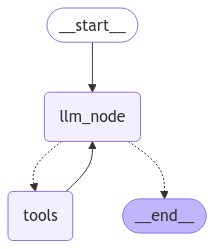

In [39]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(sql_agent.get_graph(xray=1).draw_mermaid_png()))

In [61]:
config = {"configurable": {"thread_id": "1"}}
sql_agent.update_state(config=config, values={"messages": system_message_sql_agent})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb65c2-6116-6866-8000-5689bd910d5d'}}

In [ ]:
# this should be avoided because system messages should be dynamic
sql_agent.get_state(config=config).values

{'messages': [SystemMessage(content="You are an agent designed to interact with a SQL database.\nGiven an input question, create a syntactically correct PostgreSQL query to run, then look at the results of the query and return the answer.\nAlways limit your query to at most 5 results.\nYou can order the results by a relevant column to return the most interesting examples in the database.\nNever query for all the columns from a specific table, only ask for the relevant columns given the question.\nYou have access to tools for interacting with the database.\nOnly use the below tools. Only use the information returned by the below tools to construct your final answer.\nYou MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.\nIf you get an InsufficientPrivilege error, respond with the following message:\n\n“I'm unable to perform this operation directly. Please contact our support team at 23030009@lums.edu.pk, and t

In [41]:
from langchain_core.messages import HumanMessage

def stream_graph_updates(graph, user_input: str, config):
    events = graph.stream(
        {"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"
    )
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(sql_agent, user_input, config=config)
    except:
        print("Invalid Input!")
        break

Goodbye!


In [43]:
from langchain_core.messages import AIMessage
snapshot = sql_agent.get_state(config=config)
for message in snapshot.values["messages"]:
    if message.type in ['ai', 'human'] and 'tool_calls' not in message.additional_kwargs:
        message.pretty_print()

In [44]:
# Conversation 1: Order Status and Details
order_status_details = [
    "Hi, my name is Umar Siddiqui and my CustomerID is 7. Can you check the status of my latest order?",
    "How much did I spend on my last order?",
    "What items did I order last time?",
    "Who is delivering my order, and how can I contact them?",
    "Are there any pending payments on my order?",
    "What’s the expected delivery time for my current order?",
    "Can I add special instructions to my ongoing order?",
    "Is there a way to add or change items in my order now?"
]

config = {"configurable": {"thread_id": "2"}}
sql_agent.update_state(config=config, values={"messages": system_message_sql_agent})
for user_input in order_status_details:
    stream_graph_updates(sql_agent, user_input, config=config)

================================ Human Message =================================

Hi, my name is Umar Siddiqui and my CustomerID is 7. Can you check the status of my latest order?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_eNFTavJzYWXN9q6Cv99HxSDC)
 Call ID: call_eNFTavJzYWXN9q6Cv99HxSDC
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

customers, deliverypersonnel, feedbackcomplaints, fooditems, orderitems, orders, payments, restaurants
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_5Sr0TqUUin1pb23ZAsGdToT6)
 Call ID: call_5Sr0TqUUin1pb23ZAsGdToT6
  Args:
    table_names: orders
  sql_db_schema (call_2QNdMjerR5GoFE51H00j7Lpp)
 Call ID: call_2QNdMjerR5GoFE51H00j7Lpp
  Args:
    table_names: orderitems


KeyboardInterrupt: 

In [ ]:

# Conversation 2: Account and Loyalty Points
account_loyalty_points = [
    "How many loyalty points do I have?",
    "Can you tell me when I last earned loyalty points?",
    "What’s my current address on file?",
    "How can I update my payment information?",
    "Can I redeem loyalty points on my next order?",
    "What’s my account’s email address?",
    "How do I reset my password?",
    "How often can I earn loyalty points?"
]

# Conversation 3: Payment and Billing Queries
payment_billing_queries = [
    "What payment method did I use for my last order?",
    "Are there any pending payments I need to clear?",
    "Can I change my payment method for an ongoing order?",
    "How do I view all my past transactions?",
    "Did I pay using Visa or JazzCash last time?",
    "Can I add a new credit card to my account?",
    "Why did my last payment fail?",
    "How can I get a receipt for my last purchase?"
]

# Conversation 4: Restaurant Information and Availability
restaurant_info_availability = [
    "What are the operating hours of Lahore Tikka House?",
    "Is there a restaurant that serves Afghani cuisine nearby?",
    "Which restaurants have the best rating?",
    "Are there any dessert options at Quetta Sajji House?",
    "Can you list all the restaurants available in Karachi?",
    "What type of food does Islamabad Café serve?",
    "Is there a place with high ratings that’s open late tonight?",
    "How far is Hyderabad Biryani Corner from my location?"
]

# Conversation 5: Food and Menu Queries
food_menu_queries = [
    "What’s on the menu at Karachi Broast?",
    "How much does a Beef Biryani cost at Hyderabad Biryani Corner?",
    "Can you suggest something spicy from Lahore Tikka House?",
    "Do any restaurants offer vegetarian options?",
    "What are the most popular items at Peshawar Chapli Kebab?",
    "Can I get a dessert recommendation from Islamabad Café?",
    "How many items does the Quetta Sajji House menu have?",
    "Are there any appetizers in the Pakistani cuisine options?"
]

# Conversation 6: Delivery Information
delivery_information = [
    "Who’s delivering my order right now?",
    "When should I expect my delivery?",
    "Can you provide contact details for the delivery person?",
    "Where is my delivery currently?",
    "What address is my order being delivered to?",
    "Is there a way to track the delivery in real-time?",
    "Has the delivery personnel started the delivery yet?",
    "Can I change the delivery address after placing the order?"
]

# Multi-Agent

In [65]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class RouterState(TypedDict):
    messages: Annotated[list, add_messages]
    route: Literal["database", "other", "tool_call"]


class Router(TypedDict):
    route: Literal["database", "other", "tool_call"]


router_tools = [tools["sql_db_list_tables"], tools["sql_db_schema"]]
router_llm = llm.bind_tools(router_tools).with_structured_output(Router)


def router_node(state: RouterState):
    system_message = "You will act as an expert routing agent where your job is to carefully analyze the user question and route it to one of the specialized agents in the team. You have access to tools for interacting with the database that you can execute to get more context about the connected SQL database. To start, you should ALWAYS look at the tables in the database to see what data is available in the database. Do NOT skip this step. Then you should query the schema of the most relevant tables if you need more context. After processing all this context, you should decide whether the user question can be answered by the SQL agent or not."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    route = router_llm.invoke(messages)
    return {"route": route["route"]}


def normal_llm_node(state: RouterState):
    system_message = "You are a helpful AI assistant. Answer the user questions."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def route_after_prediction(state: RouterState,) -> Literal["sql_agent_node", "normal_llm_node", "tools"]:
    if state["route"] == "database":
        return "sql_agent_node"
    elif state["route"] == "tool_call":
        return "tools"
    else:
        return "normal_llm_node"

graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("sql_agent_node", sql_agent)
graph.add_node("tools", ToolNode(router_tools))

graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("tools", "router_node")
graph.add_edge("normal_llm_node", END)
graph.add_edge("sql_agent_node", END)

graph = graph.compile(checkpointer=memory)

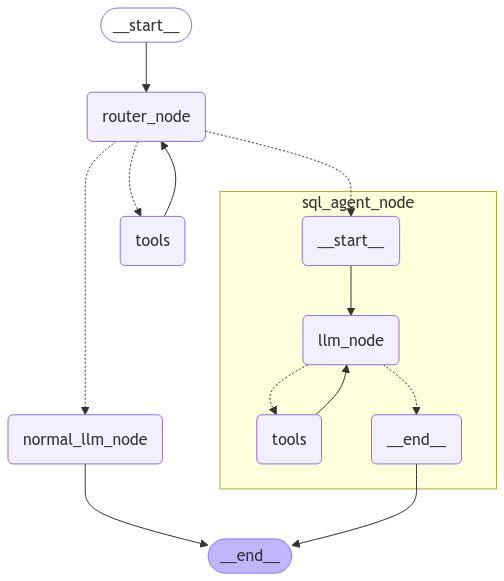

In [73]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [67]:
config = {"configurable": {"thread_id": "11"}}

inputs = {"messages": [{"role": "user", "content": "Hello! Tell me a joke."}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

inputs = {"messages": [{"role": "user", "content": "what is the status of order number 3?"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

# inputs = {"messages": [{"role": "user", "content": "What do you know about FoodPanda?"}]}
# for update in graph.stream(inputs, config=config, stream_mode="updates"):
#     print(update)

{'router_node': {'route': 'other'}}
{'normal_llm_node': {'messages': [AIMessage(content='Sure! Why did the scarecrow win an award? \n\nBecause he was outstanding in his field!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 30, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-55f71d38-2131-4eef-bd3a-f88e5e17d744-0', usage_metadata={'input_tokens': 30, 'output_tokens': 20, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'router_node': {'route': 'database'}}
{'sql_agent_node': {'messages': [HumanMessage(content='Hello! Tell me a joke.'

In [72]:
graph.get_state(config=config).values

{'messages': [HumanMessage(content='Hello! Tell me a joke.', additional_kwargs={}, response_metadata={}, id='0a4f1be0-cc1f-423c-9950-d294470410aa'),
  AIMessage(content='Sure! Why did the scarecrow win an award? \n\nBecause he was outstanding in his field!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 30, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-55f71d38-2131-4eef-bd3a-f88e5e17d744-0', usage_metadata={'input_tokens': 30, 'output_tokens': 20, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='what is the st

# Multi Agentic workflow to the next level 

In [94]:
import re
import os
from uuid import uuid4
from dotenv import load_dotenv
from pinecone import ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import TokenTextSplitter
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import SystemMessagePromptTemplate
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from pinecone import Pinecone
from langchain.memory import ConversationBufferMemory
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEndpoint
from typing import Literal, Annotated, Optional, Callable
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START, END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed import IsLastStep
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from langchain_core.tools.base import BaseTool
from langchain_core.tools import convert_runnable_to_tool

load_dotenv("/Users/tariqmehmood/code/cs-6303/RAG-Enterprise-Chatbot/sql_agent/.env", override=True)
DATABASE_URI_RW=os.environ.get("DATABASE_URI_RW")
DATABASE_URI_RO=os.environ.get("DATABASE_URI_RO")
OPENAI_API_KEY=os.environ.get("OPENAI_API_KEY")
TAVILY_API_KEY=os.environ["TAVILY_API_KEY"]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

## Customer RAG Agent

In [ ]:
rag_prompt = PromptTemplate(
    template="""
        You are a chatbot designed to answer questions from customers of an organization.
        Use the following extract from relevant documents to answer the question.

        Context: {context}
        Question: {question}
        Answer:
    """,
    input_variables=["context", "question"],
)


class DocumentLoader:
    def __init__(self, chunk_size=256, chunk_overlap=0.50):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

    def _load_and_split(self, docs_to_load):
        combined_text = ""
        for doc in docs_to_load:
            loader = PyMuPDFLoader(doc)
            documents = loader.load()
            for page in documents:
                text = page.page_content
                if "contents" in text.lower():
                    continue
                text = re.sub(r"\bPage\s+\d+\b", "", text, flags=re.IGNORECASE)
                text = re.sub(r"\n", "", text).strip()
                text = re.sub(r"[^\w\s.,?!:;\'\"()&-]", "", text)
                combined_text += text + " "
        combined_text = combined_text.strip()

        text_splitter = TokenTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=int(self.chunk_size * self.chunk_overlap),
        )
        texts = text_splitter.split_text(combined_text)
        return text_splitter.create_documents(texts)


class VectorStore:
    def __init__(self, pinecone_client, index_name, embedding_model):
        self.pc = pinecone_client
        self.index_name = index_name
        self.embeddings = embedding_model

        if self.index_name not in self.pc.list_indexes().names():
            self.pc.create_index(
                name=self.index_name,
                dimension=768,
                metric="cosine",
                spec=ServerlessSpec(cloud="aws", region="us-east-1"),
            )

        self.index = self.pc.Index(self.index_name)
        self.vector_store = PineconeVectorStore(
            index=self.index, embedding=self.embeddings
        )

    def _build(self, documents):
        uuids = [str(uuid4()) for _ in range(len(documents))]
        self.vector_store.add_documents(documents=documents, ids=uuids)

    def _as_retriever(
        self, search_type="similarity_score_threshold", search_kwargs=None
    ):
        return self.vector_store.as_retriever(
            search_type=search_type,
            search_kwargs=search_kwargs or {"k": 3, "score_threshold": 0.5},
        )


class CustomerRagAgent:
    def __init__(self, document_loader, vector_store, llm):
        self.document_loader = document_loader
        self.vector_store = vector_store
        self.retriever = self.vector_store._as_retriever()
        self.llm = llm
        self.rag_chain = (
            {
                "context": self.retriever | self._format_docs,
                "question": RunnablePassthrough(),
            }
            | rag_prompt
            | self.llm
        )

    def _format_docs(self, docs):
        return "\n\n".join([d.page_content for d in docs])

    def load_and_add_documents(self, docs_to_load):
        documents = self.document_loader._load_and_split(docs_to_load)
        self.vector_store._build(documents)

    def generate(self, query):
        query_response = self.rag_chain.invoke(query)
        return query_response


# Initialize document loader
doc_loader = DocumentLoader()

# Initialize vector store
pinecone_client = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
vector_store = VectorStore(
    pinecone_client=pinecone_client,
    index_name="customer-queries-db",
    embedding_model=HuggingFaceEmbeddings(),
)

# Create orchestrator
rag_pipeline = CustomerRagAgent(
    document_loader=doc_loader,
    vector_store=vector_store,
    llm=llm,
)

## SQL Agent

In [13]:
system_template_sql_agent = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
If you get an InsufficientPrivilege error, respond with the following message:

“I'm unable to perform this operation directly. Please contact our support team at 23030009@lums.edu.pk, and they'll assist you with this.”

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables."""

system_template_sql_agent = SystemMessagePromptTemplate.from_template(system_template_sql_agent)
system_message_sql_agent = system_template_sql_agent.format(
    dialect="PostgreSQL", top_k=5
)

db = SQLDatabase.from_uri(DATABASE_URI_RO)
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools = {tool.name:tool for tool in tools}

llm_with_tools = llm.bind_tools(list(tools.values()))


## Coordinator

In [ ]:
memory = MemorySaver()


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    is_last_step: IsLastStep
    dialog_state: Annotated[
        list[
            Literal[
                "coordinator",
                "sql_agent",
                "rag_agent",
                "assistant",
            ]
        ],
        update_dialog_stack,
    ]


class ToSqlAgent(BaseModel):
    """A tool to route the current dialog to the SQL agent."""

    route: Literal["sql_agent"] = "sql_agent"

    class Config:
        json_schema_extra = {
            "example": {
                "route": "sql_agent",
            },
        }

class ToRagAgent(BaseModel):
    """A tool to route the current dialog to the RAG agent."""

    route: Literal["rag_agent"] = "rag_agent"
    query: str = Field(description="The query to be passed to the RAG agent.")

    class Config:
        json_schema_extra = {
            "example": {
                "route": "rag_agent",
                "query": "What is the status of order number 3?",
            },
        }

class ToAssistant(BaseModel):
    """A tool to route the current dialog to the general assistant."""

    route: Literal["assistant"] = "assistant"

    class Config:
        json_schema_extra = {
            "example": {
                "route": "assistant",
            },
        }

router_llm = llm.bind_tools([ToSqlAgent, ToRagAgent, ToAssistant])


def coordinator_node(state: State):
    system_message = "You will act as an expert routing agent where your job is to carefully analyze the user question and route it to one of the specialized agents in the team. You have access to tools for interacting with the database that you can execute to get more context about the connected SQL database. To start, you should ALWAYS look at the tables in the database to see what data is available in the database. Do NOT skip this step. Then you should query the schema of the most relevant tables if you need more context. After processing all this context, you should decide whether the user question can be answered by the SQL agent or not. Furthermore, you have access to company's policy documents and you should direct related queries to the customer rag agent."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    response = router_llm.invoke(messages)
    return {"messages": [response]}

def route_coordinator(
    state: State,
):
    # route = tools_condition(state)
    # if route == END:
    #     return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToSqlAgent.__name__:
            return "enter_sql_agent"
        elif tool_calls[0]["name"] == ToRagAgent.__name__:
            return "enter_rag_agent"
        elif tool_calls[0]["name"] == ToAssistant.__name__: 
            return "enter_assistant"
    raise ValueError("Invalid route")

def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        response= {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

        return response

    return entry_node


def general_assistant_node(state: State):
    system_message = "You are a helpful AI assistant. Answer the user questions."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def sql_agent_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def customer_rag_node(state: State):
    query=state["messages"][-2].tool_calls[0]["args"]["query"]
    return {"messages": [rag_pipeline.generate(query)]}

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def pending_tool_calls(state: State) -> Literal["tools", "done"]:
    last_message = state["messages"][-1]
    if not isinstance(last_message, AIMessage):
        raise TypeError(f"Expected AIMessage, got {type(last_message)}")
    if last_message.tool_calls:
        return "tools"
    return "done"

# class CompleteOrEscalate(BaseModel):
#     """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
#     who can re-route the dialog based on the user's needs."""

#     cancel: bool = True
#     reason: str

#     class Config:
#         json_schema_extra = {
#             "example": {
#                 "cancel": True,
#                 "reason": "User changed their mind about the current task.",
#             },
#             "example 2": {
#                 "cancel": True,
#                 "reason": "I have fully completed the task.",
#             },
#             "example 3": {
#                 "cancel": False,
#                 "reason": "I need to search the user's emails or calendar for more information.",
#             },
#         }
        
# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }



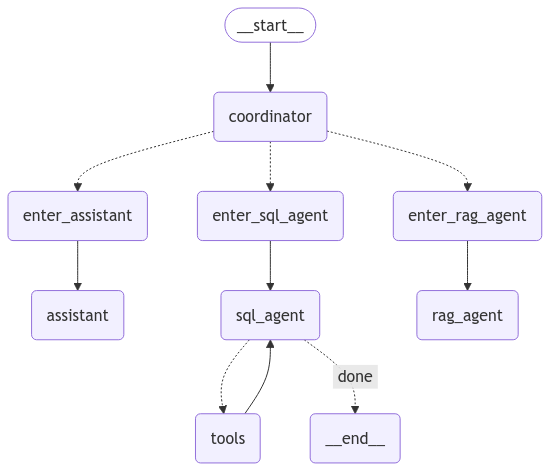

In [110]:
from IPython.display import Image, display

graph = StateGraph(State)

graph.add_node("coordinator", coordinator_node)
graph.add_node("assistant", general_assistant_node)
graph.add_node("sql_agent", sql_agent_node)
graph.add_node("rag_agent", customer_rag_node)
# graph.add_node("tools", ToolNode(router_tools))
graph.add_node("tools", create_tool_node_with_fallback(list(tools.values())))

graph.add_conditional_edges(
    "coordinator",
    route_coordinator,
    [
        "enter_sql_agent",
        "enter_rag_agent",
        "enter_assistant",
    ],
)


graph.add_node("enter_sql_agent", create_entry_node("SQL Agent", "sql_agent"))
graph.add_node("enter_rag_agent", create_entry_node("Customer RAG Agent", "rag_agent"))
graph.add_node("enter_assistant", create_entry_node("General Assistant", "assistant"))
graph.add_edge("enter_sql_agent", "sql_agent")
graph.add_edge("enter_rag_agent", "rag_agent")
graph.add_edge("enter_assistant", "assistant")

graph.add_edge(START, "coordinator")
# graph.add_conditional_edges("coordinator", route_after_prediction)
graph.add_edge("tools", "sql_agent")

graph.add_conditional_edges(
    "sql_agent", pending_tool_calls, {"tools": "tools", "done": END}
)

# graph.add_node("leave_skill", pop_dialog_state)
# graph.add_edge("leave_skill", "coordinator")

graph = graph.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [115]:
config = {"configurable": {"thread_id": "1"}}

# inputs = {"messages": [{"role": "user", "content": "Hello! Tell me a joke."}]}
# inputs = {"messages": [{"role": "user", "content": "what is the refund policy?"}]}
inputs = {"messages": [{"role": "user", "content": "what is the status of order number 3?"}]}
inputs = {"messages": [{"role": "user", "content": "Can I change the delivery address after placing the order?"}]}
# inputs = {"messages": [{"role": "user", "content": "please update the status of order number 3 in the sql database to Rejected."}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'coordinator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lNXPHWLzl1TaiRyIrqyh2UU0', 'function': {'arguments': '{"query":"Can I change the delivery address after placing the order?"}', 'name': 'ToRagAgent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1657, 'total_tokens': 1683, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5043a2f4-37b1-4731-8d93-2c217ffc260c-0', tool_calls=[{'name': 'ToRagAgent', 'args': {'query': 'Can I change the delivery address after placing the order?'}, 'id': 'call_lNXPHWLzl1TaiRyIrqyh2UU0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1657, 'outpu

In [114]:
for message in graph.get_state(config=config).values['messages']:
    message.pretty_print()

================================ Human Message =================================

what is the refund policy?
================================== Ai Message ==================================
Tool Calls:
  ToRagAgent (call_Piso7l9j3kPL2SLutl4mg8z4)
 Call ID: call_Piso7l9j3kPL2SLutl4mg8z4
  Args:
    query: What is the refund policy?
================================= Tool Message =================================

The assistant is now the Customer RAG Agent. Reflect on the above conversation between the host assistant and the user. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as the proxy for the assistant.
================================== Ai Message ==================================

The refund policy for Uber Eats allows for refunds in various circumstances, but they are not guaranteed for every issue. Customers are encouraged to report any probl

In [108]:
graph.get_state(config=config).values['messages'][1].tool_calls[0]['args']['query']

'What is the refund policy?'